<center><h1>Build and Train Model 3</h1></center>

In [70]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import sklearn.model_selection
import random
from random import sample

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, average_precision_score

pd.set_option('display.max_columns', None)# Display all the columns
pd.set_option('display.max_rows', None)# Display all the rows

## Do some early processing of your metadata for easier model training:

In [2]:
## Load the NIH data to data_df

data_df = pd.read_csv('/data/Data_Entry_2017.csv')

# Create a list of image path

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', data_df.shape[0])

# Add a column called 'path' into  and insert all_image_path

data_df['path'] = data_df['Image Index'].map(all_image_paths.get)
data_df.head(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
dtyp

In [4]:
# Drop Unnamed: 11

data_df = data_df.drop('Unnamed: 11', axis=1)

To understand distributions of variables as they relate to pneumonia, let's try splitting up the 'Finding Labels' column into one additional column per disease and put a binary flag in that column to indicate the presence of the disease.

In [5]:
# Create all_labels which consist of the diseases present in the dataset

all_labels = np.unique(list(chain(*data_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

# Verify all_labels
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# Create column per disease and put a binary flag
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data_df[c_label] = data_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

data_df.head(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/data/images_001/images/00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia. One (1) is represented as'Positive', 0 as 'Negative'. 

data_df['Pneumonia_class']= data_df['Pneumonia'].copy()
data_df['Pneumonia_class']=data_df['Pneumonia_class'].replace(1, 'Positive').replace(0, 'Negative')
data_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/data/images_001/images/00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative


In [7]:
# Throw away patient with age above 95

data_df = data_df[(data_df['Patient Age'] <= 95)]
len(data_df)

112104

In [8]:
# Check the number of Pneumonia cases in data_df

len(data_df[data_df['Pneumonia']==1])

1430

## Create your training and testing data:

From the EDA, we know that Pneumonia isn't a very common finding in this dataset, so **we want to maximize our data** so that we can use all of the true Pneumonia cases in training. Since the machine learning model only train on images of patient's lungs, in some cases, we will use more than one images of a patient's lung. Later, we will use ImageDataGenerator to augment the training images to expand our training data.  

First, we split the data into training set (train_df) and test set (val_df) with the test size equal to 20% of the whole dataset. Also, we make sure the proportion of Pneumonia is similar in both train_df and valid_df.

In [9]:
# we split the data into training set (train_df) and test set (val_df) with the test size 
# equal to 20% of the whole dataset. We will stratify the Pneumonia cases.

train_df, val_df = sklearn.model_selection.train_test_split(data_df, test_size = 0.2, stratify = data_df["Pneumonia"], random_state = 0)
print("Training set ", train_df.shape)
print("Validation set ", val_df.shape)    

Training set  (89683, 28)
Validation set  (22421, 28)


Then we throw away some images that don't contain Pneumonia so we have the same amount of positive and negative cases of Pneumonia in Training.

In [10]:
# Find positive and negative indexes of Pneumonia from train_df

p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

# Set random seed so we can reproduce the same data

random.seed(0)

# Take a ramdom sample of negative indexes and create a new train_df which rows consist of 
# previous positive indexes and random sample of negative indexes

np_sample = random.sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [11]:
# Find the percentatge of Pneumonia in train_df. 

(sum(train_df["Pneumonia"])/len(train_df))*100

50.0

In [12]:
# Check the length of train_df

len(train_df)

2288

Finaly, we throw away some negative cases of Pneumonia in val_df so we only have 20% positive Pneumonia cases. By doing so, the amount of cases in val_df is more reasonable or realistic.

In [13]:
# Find positive and negative indexes of Pneumonia from val_df

p_inds2 = val_df[val_df.Pneumonia==1].index.tolist()
np_inds2 = val_df[val_df.Pneumonia==0].index.tolist()

# Take a ramdom sample of negative indexes and create a new val_df which rows consist of 
# previous positive indexes and random sample of negative indexes

np_sample2 = random.sample(np_inds2,len(p_inds2*4))
val_df = val_df.loc[p_inds2 + np_sample2]

In [14]:
# Find the percentatge of Pneumothorax in val_df. 

(sum(val_df["Pneumonia"])/len(val_df))*100

20.0

In [15]:
# Check the length of val_df

len(val_df)

1430

### Explore the Distribution of the Training Set

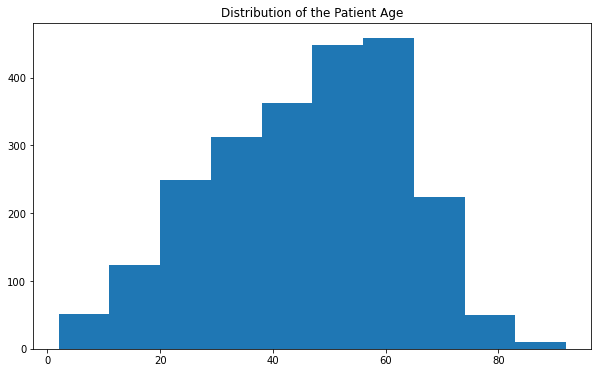

In [16]:
# Below is the histogram of all patient ages in train_df

plt.figure(figsize=(10,6))
plt.hist(train_df['Patient Age'])
plt.title('Distribution of the Patient Age')
plt.show()

Although the distribution of age in train_df is not quite the same with the distribution of the whole population in EDA, it is still OK, since the distribution is not deviate too much from the one in the EDA. 

In [17]:
# We check the gender distribution of the Patient Gender

(train_df['Patient Gender'].value_counts())/len(train_df)

M    0.567745
F    0.432255
Name: Patient Gender, dtype: float64

The above result shows that the male is a little more than female patients. This is OK since from EDA, we know that the distribution of male is a little higher than that of female.

In [18]:
(train_df['View Position'].value_counts())/len(train_df)

PA    0.515297
AP    0.484703
Name: View Position, dtype: float64

The above result shows that PA is a little more than AP. This is also OK since from EDA, we know that the distribution of PA is also a little higher than that of AP.

# Now we can begin our model-building & training

#### Perform some image augmentation on your data

In [19]:
## This is the image size that VGG16 takes as input

IMG_SIZE = (224, 224)

In [20]:
def my_image_augmentation():
    
    train_idg = ImageDataGenerator(rescale=1. / 255.0, # rescale or normalize
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=10, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              brightness_range=[0.8,1.2] # augment the brightmenst   
                              )
    
    return train_idg

def make_train_gen(vargs):
    
    train_gen = vargs.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 64
                                         )

    return train_gen

def make_val_gen():
    
    ## Validation data should not be augmented! 
    # We only want to do some basic intensity rescaling here
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0) # rescale or normalize
    
    val_gen = val_idg.flow_from_dataframe(dataframe=val_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32)
    return val_gen

In [21]:
img_aug = my_image_augmentation()
train_gen = make_train_gen(img_aug)
val_gen = make_val_gen()

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [22]:
## May want to pull a single large batch of random validation data for testing after each epoch:

valX, valY = val_gen.next()

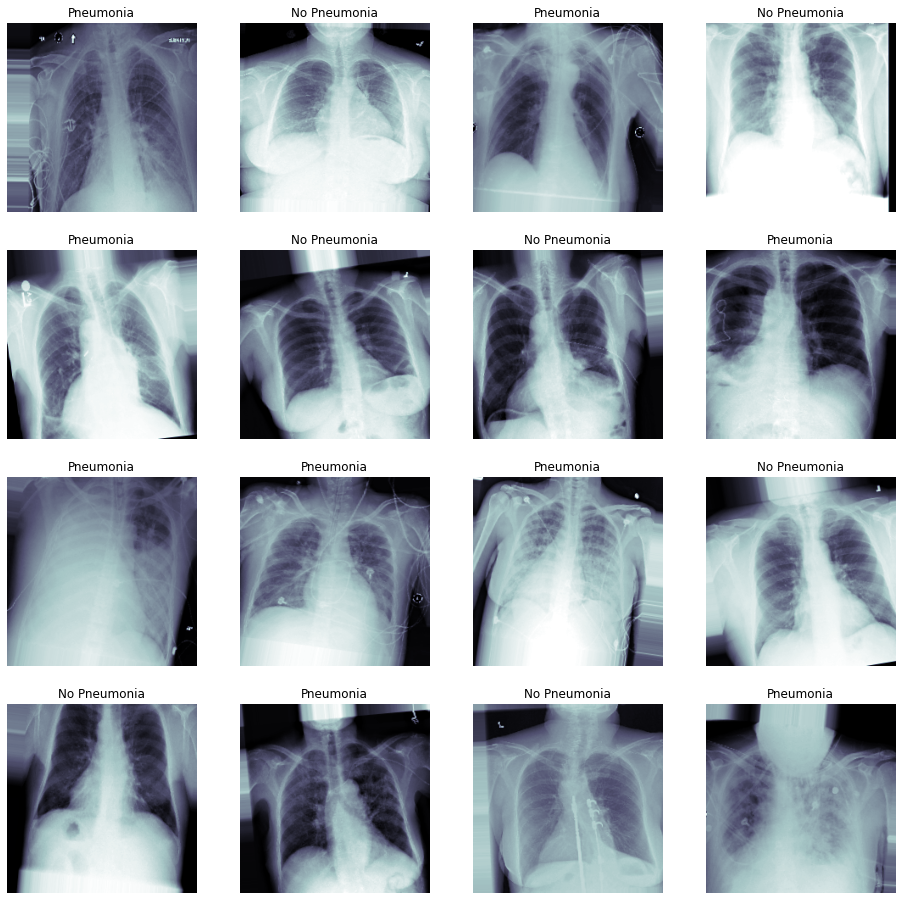

In [23]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

We will freeze all layers except the final convolutional layer of VGG16, and add a dense (fully connected) layers.

In [24]:
# Here we use a pre-trained network downloaded from Keras for fine-tuning. 

def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    
    # Freeze all layers except for the final convolutional layer of VGG16
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model

In [25]:
# Load and see the summary of our vgg model

vgg_model = load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [26]:
def build_my_model():
    
    my_model = Sequential()
    
    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)
    
    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    my_model.add(Flatten())
    
    #my_model.add(Dropout(0.2))
    #my_model.add(Dense(1024, activation='relu'))

    #my_model.add(Dropout(0.2))
    #my_model.add(Dense(512, activation='relu'))

    #my_model.add(Dropout(0.2))
    my_model.add(Dense(256, activation='relu'))
    
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 

    my_model.add(Dense(1, activation='sigmoid'))
    #my_model.add(Dense(1, activation='softmax'))
    
    ## Set our optimizer, loss function, and learning rate 

    optimizer = Adam(learning_rate=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return my_model

In [27]:
# Load and see the summary of our my_model

build_my_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [28]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model3.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [29]:
## train your model

my_model = build_my_model()

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 50, 
                           callbacks = callbacks_list)

Epoch 1/50
36/36 [==============================] - 91s 3s/step - loss: 0.7073 - binary_accuracy: 0.5122 - val_loss: 0.7021 - val_binary_accuracy: 0.2188

Epoch 00001: val_loss improved from inf to 0.70206, saving model to xray_class_my_model3.best.hdf5
Epoch 2/50
36/36 [==============================] - 70s 2s/step - loss: 0.6945 - binary_accuracy: 0.5157 - val_loss: 0.7568 - val_binary_accuracy: 0.1875

Epoch 00002: val_loss did not improve from 0.70206
Epoch 3/50
36/36 [==============================] - 72s 2s/step - loss: 0.6942 - binary_accuracy: 0.5122 - val_loss: 0.6761 - val_binary_accuracy: 0.8125

Epoch 00003: val_loss improved from 0.70206 to 0.67606, saving model to xray_class_my_model3.best.hdf5
Epoch 4/50
36/36 [==============================] - 71s 2s/step - loss: 0.6937 - binary_accuracy: 0.5039 - val_loss: 0.6788 - val_binary_accuracy: 0.8125

Epoch 00004: val_loss did not improve from 0.67606
Epoch 5/50
36/36 [==============================] - 71s 2s/step - loss: 0.69

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [30]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 11ms/step


In [31]:
# See the value of pred_Y

pred_Y

array([[0.40804225],
       [0.6694653 ],
       [0.539342  ],
       [0.42243704],
       [0.31354153],
       [0.30802703],
       [0.42454582],
       [0.5564955 ],
       [0.4345658 ],
       [0.4156818 ],
       [0.6207533 ],
       [0.39131203],
       [0.4412013 ],
       [0.29425654],
       [0.55702245],
       [0.35454515],
       [0.4387967 ],
       [0.47847033],
       [0.5226132 ],
       [0.43463233],
       [0.4180376 ],
       [0.6412517 ],
       [0.28903025],
       [0.41371557],
       [0.46712628],
       [0.37924054],
       [0.29754406],
       [0.4734795 ],
       [0.42816475],
       [0.38484436],
       [0.32478422],
       [0.4454926 ]], dtype=float32)

In [32]:
# Check the length of pred_Y

len(pred_Y)

32

In [33]:
# See the value of valY

valY

array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [61]:
# function to plot the roc_curve and show auc
def plot_roc_curve(ground_truth, probability):
    fpr, tpr, thresholds = roc_curve(ground_truth, probability)
    AUC = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate')
    plt.show()
    print('AUC: ', AUC)

# function to plot the precision_recall_curve. 
def plot_precision_recall_curve(ground_truth, probability):
    precision, recall, _ = precision_recall_curve(ground_truth, probability)
    AP = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(ground_truth, probability))
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    print('AP: ', AP) #average_precision_score 
    
# function to plot the precision_recall_curve with threshold
def plot_precision_recall_vs_threshold(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "b--", label="Precision")
    plt.plot(threshold, recall[:-1], "g-", label="Recall")
    plt.legend(["Precision", "Recall"], loc ="upper right")
    plt.title('Precision & Recall vs Threshold')
    plt.xlabel('Threshold')
    plt.show   

# function to plot history (loss and accuracy of training and validation set)    
def plot_history(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.title('Training Loss and Accuracy on Dataset')
    plt.ylabel('Loss / Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Train Accuracy','Val Loss', 'Val Accuracy'], loc='upper right')
    plt.show()
    
# function to calculate the F1 score
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

# function to plot f1 score vs thershold 
def plot_f1_vs_threshold(precision, recall, threshold):
    f1 = calc_f1(precision[:-1], recall[:-1])        
    plt.plot(threshold, f1, linewidth=2)
    plt.ylabel('F1_score')
    plt.xlabel('Threshold')
    plt.show()

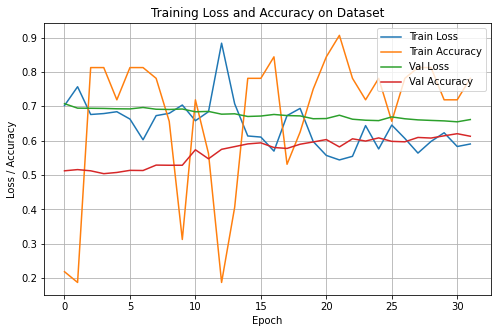

In [35]:
# Plot history

plot_history(history)

The val loss (green) decreases from epoch 0 to 22, then does not improve or decrease anymore. This means the model stops learning after epoch 22. Although the train loss (blue) fluctuates, we see that as the epoch increases, the range of fluctuation becomes smaller which indicates that it starts to stabilize. Also we see a decreasing trend in the train loss as the epoch increases. At the last few epochs, the train loss is a little bit below val loss which indicates that our model is somewhat overfit. However, the gap between train loss and val loss at the last few epochs is small, therefore the model is still acceptable.   

### Note about Precision, Recall, and F1 Score
__Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

__Recall__ is true positive rate (TPR). It is defined as: Recall =  TP / (TP + FN)

__False Positive Rate (FPR)__ tells us what proportion of the negative class got incorrectly classified by the classifier. FPR = FP / (TN + FP) = 1 - Specificity

__F1 score:__  F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

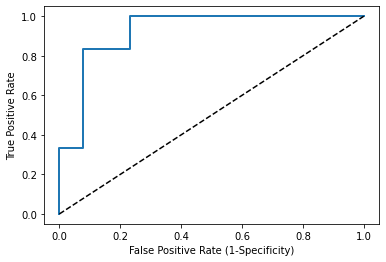

AUC:  Pneumonia (AUC:0.92)


In [36]:
# Plot roc_curve with AUV value

plot_roc_curve(valY, pred_Y)

The AUC value is 0.92, this means that there is a high chance that the model will be able to distinguish the positive class values from the negative class values. This is because the model is able to detect more True Positive and True Negative than False Negative and False Positive.

Note that ROC curves can present an overly optimistic or misleading picture of the model on datasets with a class imbalance. (We know that we have 20% of Pneumonia in our validation set).

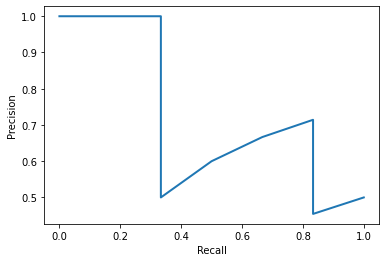

AP:  Pneumonia (AP Score:0.75)


In [37]:
# Plot precision_recall curve

plot_precision_recall_curve(valY, pred_Y)

The Average Precision (AP) score is 0.75 which gives us more confidence that a positive test result is actually positive since it has low false positive.

Using the above plot, we have to decide what value of recall and precision which we want for our model. We have to balance the precision and recall score since if a model has high recall but low precision, then the model classifies most of the positive samples correctly but it has many false positives (i.e. classifies many Negative samples as Positive). When a model has high precision but low recall, then the model is accurate when it classifies a sample as Positive but it may classify only some of the positive samples.   

Let's plot precision & recall curve with thereshold.

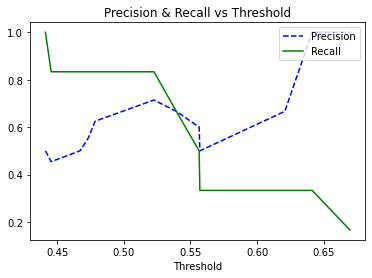

In [58]:
# Plot precision_recall curve with threshold

precision, recall, threshold = precision_recall_curve(valY, pred_Y)
plot_precision_recall_vs_threshold(precision, recall, threshold)

Below we plot F1-score cureve vs thereshold.

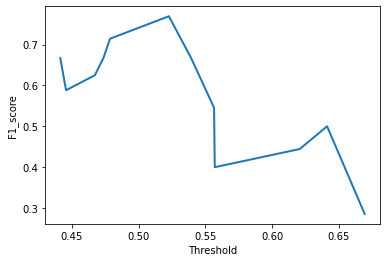

In [62]:
# Plot f1 score vs thershold 

precision, recall, threshold = precision_recall_curve(valY, pred_Y)
plot_f1_vs_threshold(precision, recall, threshold)

From our previous explanation, we want to have a balance precision and recall value. Therefore, we will use F1-score which is the harmonic average of the precision and recall to choose our threshold. In the above plot, we see the F1-score is the highest at about 7.6, and the threshold is about 0.52. 

If we trace back this threshold to the precision & recall curve vs threshold plot, we see that the recall value is about 0.83 and the precision value is about 0.71 which is not bad. At these values, we can have more confidence that a positive test result is actually positive since it has low false positive (precision) and be confident that a negative test result is truly negative since it has low false negative (recall).

Let's find the precise threshold.

In [40]:
# Check the values of precision

precision

array([0.5       , 0.45454545, 0.5       , 0.55555556, 0.625     ,
       0.71428571, 0.66666667, 0.6       , 0.5       , 0.66666667,
       1.        , 1.        , 1.        ])

In [41]:
# Check the values of recall

recall

array([1.        , 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.66666667, 0.5       , 0.33333333, 0.33333333,
       0.33333333, 0.16666667, 0.        ])

In [51]:
# Check the values of threshold

threshold

array([0.4412013 , 0.4454926 , 0.46712628, 0.4734795 , 0.47847033,
       0.5226132 , 0.539342  , 0.5564955 , 0.55702245, 0.6207533 ,
       0.6412517 , 0.6694653 ], dtype=float32)

In [63]:
# Find the values of precision, recall, threshold

precision, recall, threshold = precision_recall_curve(valY, pred_Y)

# From the precision value above, use the highest value < 1 as the precision value

precision_value = 0.71428571
#recall_value = 1
idx = (np.abs(precision - precision_value)).argmin() 
#idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(threshold[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.7142857142857143
Recall is: 0.8333333333333334
Threshold is: 0.5226132
F1 Score is: 0.7692307692307692


We found that the best threshold is 0.5226 with precision 0.7143, recall 0.8333, and F1-score 0.7692.

In [64]:
# Plot the confusion matrix

algorithm = (pred_Y > threshold[idx])
cf_matrix = confusion_matrix(valY,algorithm, labels=[0,1])
cf_matrix

array([[24,  2],
       [ 2,  4]])

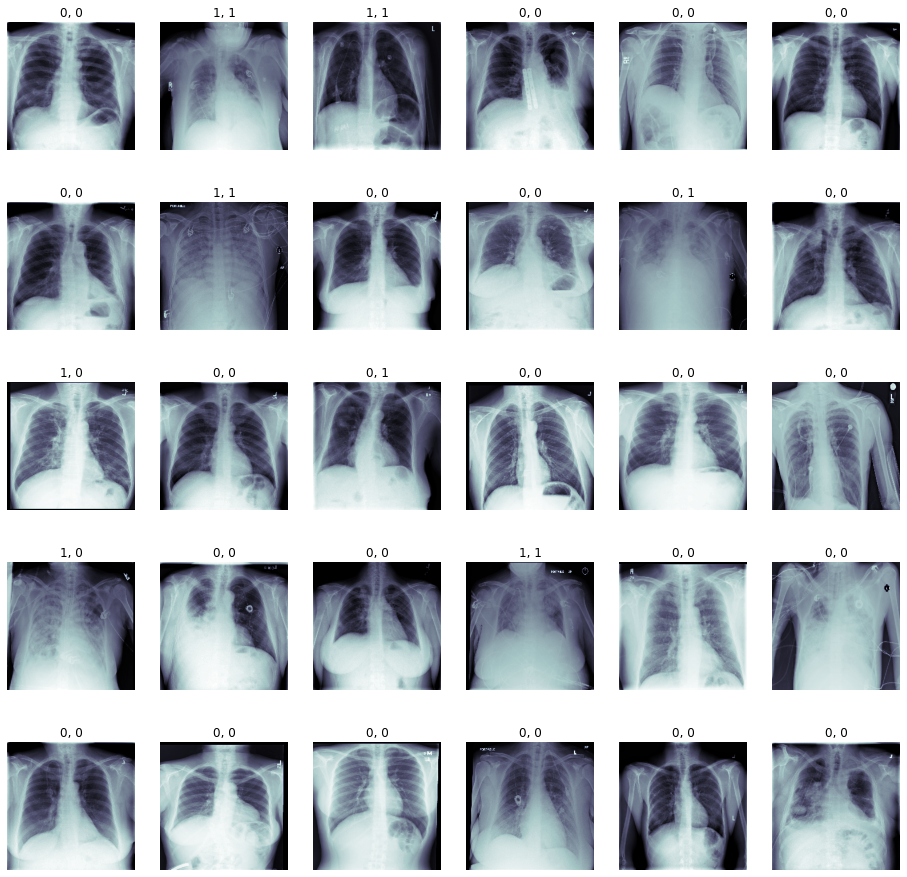

In [65]:
## Let's look at some examples of true vs. predicted with our best model: 

YOUR_THRESHOLD = threshold[idx]

fig, m_axs = plt.subplots(5, 6, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:30], valY[0:30], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y == 1: 
         if pred_Y[i] > YOUR_THRESHOLD:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > YOUR_THRESHOLD: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

In [66]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model3.json", "w") as json_file:
    json_file.write(model_json)